In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import scipy.stats

plt.rcParams["figure.figsize"]=(20, 10)

In [2]:
df = pd.read_pickle('/home/maltesepoodle/datasets/rsna/dicom_meta_train.pickle')
# drop columns with missing data
# df.dropna(axis=1, inplace=True)
df.head()
df.columns

Index(['BraTS21ID', 'dataset', 'type', 'dicom_src', 'AccessionNumber',
       'AcquisitionMatrix', 'B1rms', 'BitsAllocated', 'BitsStored', 'Columns',
       'ConversionType', 'DiffusionBValue', 'DiffusionGradientOrientation',
       'EchoNumbers', 'EchoTime', 'EchoTrainLength', 'FlipAngle', 'HighBit',
       'HighRRValue', 'ImageDimensions', 'ImageFormat', 'ImageGeometryType',
       'ImageLocation', 'ImageOrientation', 'ImageOrientationPatient',
       'ImagePosition', 'ImagePositionPatient', 'ImageType', 'ImagedNucleus',
       'ImagingFrequency', 'InPlanePhaseEncodingDirection',
       'InStackPositionNumber', 'InstanceNumber', 'InversionTime',
       'Laterality', 'LowRRValue', 'MRAcquisitionType',
       'MagneticFieldStrength', 'Modality', 'NumberOfAverages',
       'NumberOfPhaseEncodingSteps', 'PatientID', 'PatientName',
       'PatientPosition', 'PercentPhaseFieldOfView', 'PercentSampling',
       'PhotometricInterpretation', 'PixelBandwidth', 'PixelPaddingValue',
       'Pixe

In [3]:
sdf = df[["BraTS21ID", "type", "PercentPhaseFieldOfView", "AcquisitionMatrix", "EchoTime", "InversionTime", "PixelSpacing", "ImageOrientationPatient"]]
sdf.head()

,BraTS21ID,type,PercentPhaseFieldOfView,AcquisitionMatrix,EchoTime,InversionTime,PixelSpacing,ImageOrientationPatient
0,00494,T1w,90.0,"[0, 256, 256, 0]",None,None,"[1, 1]","[0.99821, 0.05832, -0.01312, -0.05974, 0.96542..."
1,00494,T1w,90.0,"[0, 256, 256, 0]",None,None,"[1, 1]","[0.99821, 0.05832, -0.01312, -0.05974, 0.96542..."
2,00494,T1w,90.0,"[0, 256, 256, 0]",None,None,"[1, 1]","[0.99821, 0.05832, -0.01312, -0.05974, 0.96542..."
3,00494,T1w,90.0,"[0, 256, 256, 0]",None,None,"[1, 1]","[0.99821, 0.05832, -0.01312, -0.05974, 0.96542..."
4,00494,T1w,90.0,"[0, 256, 256, 0]",None,None,"[1, 1]","[0.99821, 0.05832, -0.01312, -0.05974, 0.96542..."


In [4]:
# get in plane prescription 
def det_orientation(v):
    """ 
    converts real-valued patient orientation tuple to a textual orientation label
    
    scraped and modified from this discussion: 
    https://www.kaggle.com/davidbroberts/determining-mr-image-planes/notebook?fbclid=IwAR3K2h5vcGrt1EZqV23ZyhKwgGa3-k12wL976AdZyW8VG5LMeyyZk4Z1t14
    """
    v = np.round(v).astype(int)
    row_x = v[0]
    row_y = v[1]
    col_x = v[3]
    col_y = v[4]
    
    if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 0:
        return "Coronal"

    if row_x == 0 and row_y == 1 and col_x == 0 and col_y == 0:
        return "Sagittal"

    if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 1:
        return "Axial"

    return "Unknown"

sdf["Orientation"] = sdf["ImageOrientationPatient"].apply(det_orientation)

# calculate number of slices
def det_slices(df):
    try:
        return df["InversionTime"]/df["EchoTime"]
    except: 
        return None
sdf["Slices"] = sdf["InversionTime"]/sdf["EchoTime"]

# get matrix sizes
def get_sizes(x):
    try:
        return x[1]*x[2]
    except:
        return None

matrix_size = sdf["AcquisitionMatrix"].apply(get_sizes)
sdf["pixelSize"] = sdf["PercentPhaseFieldOfView"]/matrix_size
sdf["pixelSize"].replace(np.inf, None, inplace=True)



<ipython-input-4-001ce07d861e>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf["Orientation"] = sdf["ImageOrientationPatient"].apply(det_orientation)
<ipython-input-4-001ce07d861e>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf["Slices"] = sdf["InversionTime"]/sdf["EchoTime"]
<ipython-input-4-001ce07d861e>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [11]:
#split frames
flair_df = sdf[sdf["type"] == "FLAIR"]
T1w_df = sdf[sdf["type"] == "T1w"]
T2w_df = sdf[sdf["type"] == "T2w"]
T1wCE_df = sdf[sdf["type"] == "T1wCE"]

In [6]:
sdf.columns

Index(['BraTS21ID', 'type', 'PercentPhaseFieldOfView', 'AcquisitionMatrix',
       'EchoTime', 'InversionTime', 'PixelSpacing', 'ImageOrientationPatient',
       'Orientation', 'Slices', 'pixelSize'],
      dtype='object')

In [25]:
def get_plots(df):
    fig, axs = plt.subplots(2,2)
    axs[0,0].hist(df["pixelSize"].dropna(axis=0))
    axs[0,0].set_title("Pixel Size")
    # get number of pix size nans dropped
    nans_pix_size = len(df["pixelSize"]) - len(df["pixelSize"].dropna(axis=0))
    
    axs[0,1].scatter(
        df["PixelSpacing"].apply(lambda x: x[0]),
        df["PixelSpacing"].apply(lambda x: x[1])
    )
    axs[0,1].set_title("Pixel Spacing")
    
    ori_counts = [
        len(df[df["Orientation"] == "Axial"]),
        len(df[df["Orientation"] == "Coronal"]),
        len(df[df["Orientation"] == "Sagittal"]),
        len(df[df["Orientation"] == "Unknown"])
    ]
    axs[1,0].bar(
        ["Axial", "Coronal", "Sagittal", "Unknown"],
        ori_counts
    )
    axs[1,0].set_title("In-plane Prescription")
    axs[1,1].hist(
        df["AcquisitionMatrix"].apply(get_sizes).dropna(axis=0)
    )
    axs[1,1].set_title("Matrix Size")
    # get number of matrix size nans dropped 
    nans_matrix_size = len(df["AcquisitionMatrix"].apply(get_sizes)) - \
        len(df["AcquisitionMatrix"].apply(get_sizes).dropna(axis=0))
    return {"pixel size nans": nans_pix_size, "matrix size nans": nans_matrix_size}

{'pixel size nans': 1152, 'matrix size nans': 1152}

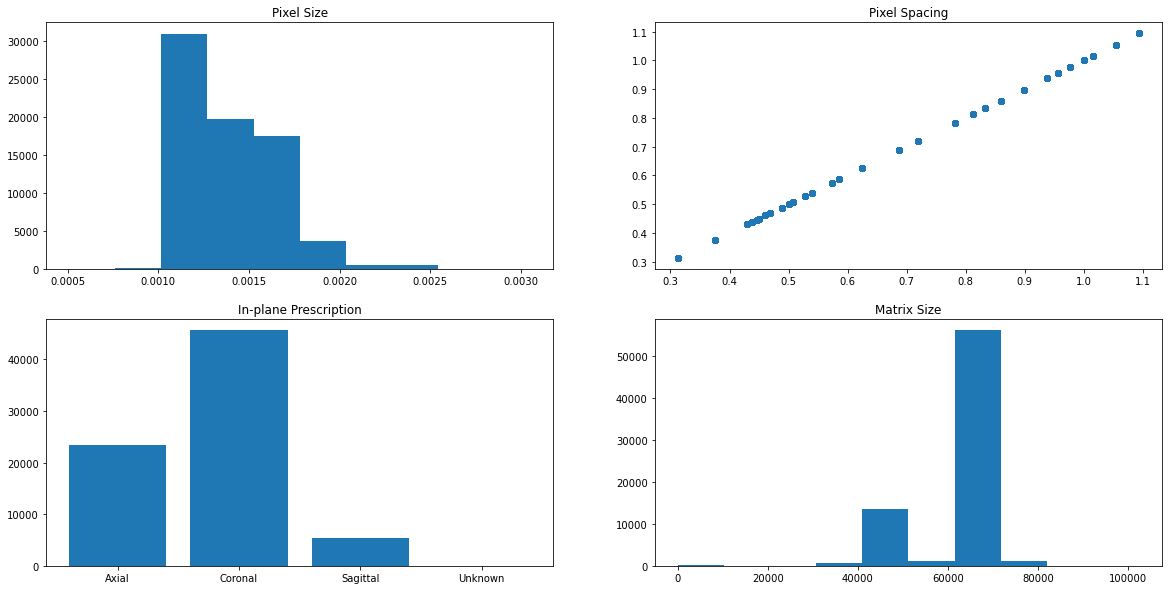

In [26]:
get_plots(flair_df)

{'pixel size nans': 0, 'matrix size nans': 0}

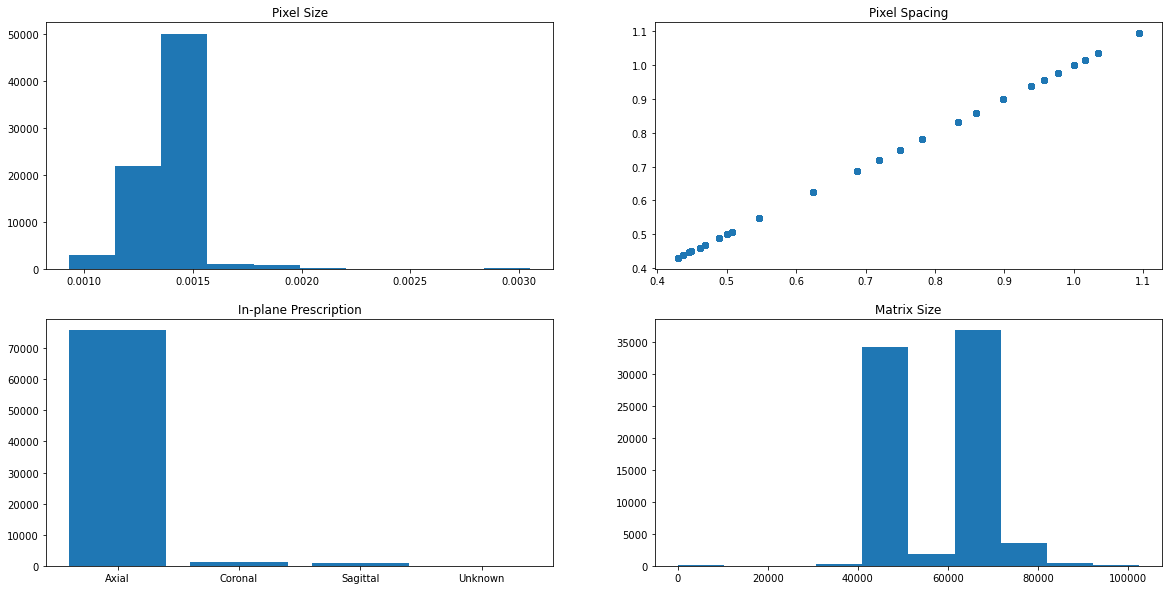

In [27]:
get_plots(T1w_df)

{'pixel size nans': 62, 'matrix size nans': 62}

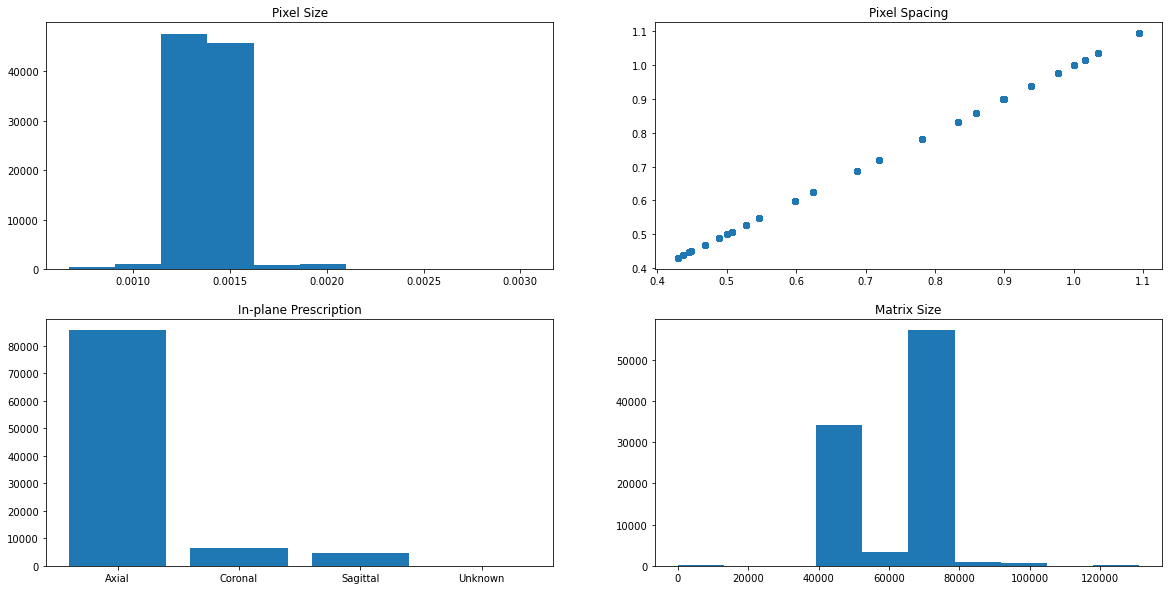

In [28]:
get_plots(T1wCE_df)

{'pixel size nans': 188, 'matrix size nans': 188}

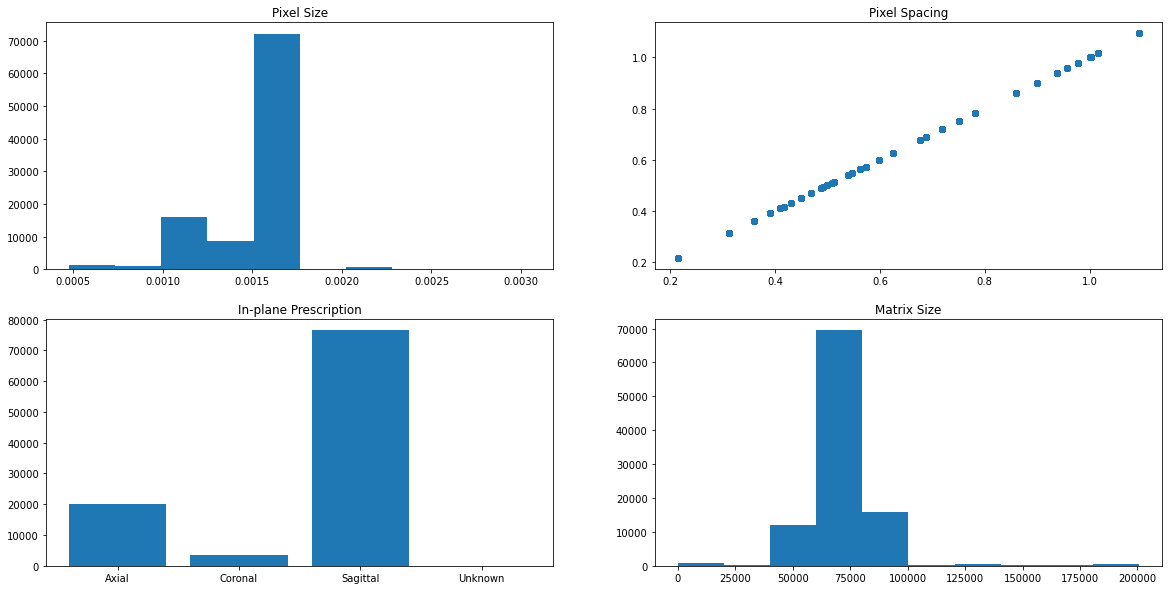

In [29]:
get_plots(T2w_df)